In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import glob
import os
import sys
import logging
from itertools import chain

import requests
from tqdm import tqdm, tqdm_notebook, tnrange
#tqdm = tqdm_notebook

import vigra
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from numba import jit

from dvidutils import LabelMapper
from libdvid import DVIDNodeService

from neuclease.dvid import *
from neuclease.util import Timer
from neuclease.misc import find_best_plane

In [ ]:
from DVIDSparkServices.spark_launch_scripts.janelia_lsf.lsf_utils import get_hostgraph_url

In [ ]:
handler = logging.StreamHandler(sys.stdout)
root_logger = logging.getLogger()
root_logger.handlers = []
root_logger.addHandler(handler)
root_logger.setLevel(logging.INFO)
logging.getLogger('kafka').setLevel(logging.WARNING)

In [ ]:
cd /nrs/flyem/bergs/complete-ffn-agglo/

In [6]:
!uname -n

e05u20.int.janelia.org


In [7]:
pwd

'/nrs/flyem/bergs/complete-ffn-agglo'

In [ ]:
#sc

### Hostgraph URLS

In [ ]:
print("This notebook:")
print(get_hostgraph_url(os.environ["LSB_JOBID"]))
print("Cluster:")
print(get_hostgraph_url(os.environ["MASTER_BJOB_ID"]))

### UUIDs

In [8]:
# The starting agglo
initial_agglo = DvidInstanceInfo('emdata3:8900', 'ac901', 'segmentation')

# The uuid used when loading the neo4j instance (for 'important bodies')
neo4j_reference = DvidInstanceInfo('emdata3:8900', '52f9', 'segmentation')

# The last supervoxel splits: One past the neo4j node
analysis_node = DvidInstanceInfo('emdata3:8900', '662e', 'segmentation')

# We won't be using this...
current_master = DvidInstanceInfo('emdata3:8900', '7e52', 'segmentation')

### Load neo4j-defined important bodies; append final splits

In [ ]:
# This list was generated from node 52f9
important_bodies_path = '/nrs/flyem/bergs/complete-ffn-agglo/bodies-0.5-from-neuprint-52f9.csv'
important_bodies = pd.read_csv(important_bodies_path, header=0, usecols=['bodyId'], dtype=np.uint64)['bodyId']
important_bodies = set(important_bodies)

# Read last set of new bodies (from analysis node, after neo4j was loaded).
msgs = read_kafka_messages(analysis_node, 'split', 'leaf-only')
final_new_bodies = set(chain(*((msg['Target'], msg['NewLabel']) for msg in msgs)))

# Append final set
important_bodies |= final_new_bodies

### Load pre-filtered table

In [ ]:
# id_a, id_b -- the two supervoxel IDs
# xa, ya, za -- point from which segmentation of 'a' was started, 8 nm coordinates
# xb, yb, zb -- point from which segmentation of 'b' was started, 8 nm coordinates
# caa, cab, cba, cbb -- cXY means: fraction of voxels from the original segment Y recovered when seeding from X
# iou -- Jaccard index of the two local segmentations
# da, db -- dX means: fraction of voxels that changed value from >0.8 to <0.5 when segmenting & seeding from X;
#                     the higher this value is, the more "internally inconsistent" the segmentation resolution
#                     potentially is; higher thresholds for iou, cXY might be warranted


# This table uses SV ids from the 'analysis node', and includes only
# edges that mention at least one "important" supervoxel
with Timer("Loading edge table"):
    #combined_table = np.load('combined-filtered-table.npy')
    combined_table = np.load('combined-table-with-importances.npy')
    combined_df = pd.DataFrame(combined_table)
    
print(f"Loaded {len(combined_df) / 1e6:.1f}M edges")
print(f"Memory usage: {combined_df.memory_usage().sum() / 1e9:.1f} GB")

In [ ]:
combined_df.columns

In [ ]:
%time all_svs = pd.concat((combined_df['id_a'], combined_df['id_b']), ignore_index=True)

In [ ]:
%%time 
sv_counts = all_svs.value_counts()
unimportant_sv_counts = sv_counts[~sv_counts.index.isin(important_bodies)]
print((unimportant_sv_counts == 1).sum())

### One-hop only?

In [ ]:
len(important_bodies)

In [ ]:
def chunkify_table(table, approx_chunk_len):
    approx_chunk_len = int(approx_chunk_len)
    total_len = len(table)
    num_chunks = max(1, total_len // approx_chunk_len)
    chunk_len = total_len // num_chunks

    partitions = list(range(0, chunk_len*num_chunks, chunk_len))
    if partitions[-1] < total_len:
        partitions.append( total_len )

    for (start, stop) in zip(partitions[:-1], partitions[1:]):
        yield table[start:stop]

#### Cache chunks to disk

In [ ]:
# os.makedirs('combined-filtered-chunks', exist_ok=True)
# num_chunks = len(combined_table)//10**6
# for i, table_chunk in tqdm(enumerate(chunkify_table(combined_table, 10**6)), total=num_chunks):
#     np.save(f'combined-filtered-chunks/chunk-{i:05}.npy', table_chunk)

In [ ]:
def append_importances(i):
    chunk_path = f'/nrs/flyem/bergs/complete-ffn-agglo/combined-filtered-chunks/chunk-{i:05}.npy'
    df = pd.DataFrame(np.load(chunk_path))
    df['important_a'] = df['body_a'].isin(important_bodies)
    df['important_b'] = df['body_b'].isin(important_bodies)
    return df.to_records(index=False)

In [ ]:
#num_chunks = len(combined_table)//10**6
num_chunks = 755
#%time table_chunks = sc.parallelize(range(num_chunks)).map(append_importances).collect()

In [ ]:
table_chunks = list(map(append_importances, tnrange(num_chunks)))

In [ ]:
#combined_table = np.concatenate(table_chunks)
#%time np.save('combined-table-with-importances.npy', combined_table)

In [ ]:
%%time
onehop_table = combined_table[combined_table['important_a'] & combined_table['important_b']]
onehop_df = pd.DataFrame.from_records(onehop_table)

In [ ]:
#%time onehop_chunks = [chunk[chunk['important_a'] & chunk['important_b']] for chunk in tqdm(table_chunks)]

In [ ]:
#sum(map(len, onehop_chunks))

In [ ]:
@jit(nopython=True)
def calc_score_32nm(caa, cab, cba, cbb, iou, da, db):
    if (caa >= 0.6 and cab >= 0.6 and cba >= 0.6 and cbb >= 0.6
    and iou > 0.8 and (da <= 0.02 or db <= 0.02)):
        return 0.0 + (1.0 - iou)
    elif (caa >= 0.6 and cab >= 0.6 and cba >= 0.6 and cbb >= 0.6 and iou > 0.4):
        return 5.0 + (1.0 - iou)
    elif (caa > 0.8 and cab > 0.8):
        return 11.0 + (1.0 - min(caa, cab))
    else:
        return 11.0 + (1.0 - min(cba, cbb))


@jit(nopython=True)
def calc_score_16nm(caa, cab, cba, cbb, iou, da, db):
    if ( caa >= 0.6 and cab >= 0.6 and cba >= 0.6 and cbb >= 0.6
    and iou > 0.8 and (da <= 0.02 or db <= 0.02)):
        # This is probably wrong...
        return 3.0 + (1.0 - iou)

# This is the original function...
#         if d.id_b = 0 or e.id_b = 0:
#             if b.class == 6 and c.class == 6:
#                 return 1.0 + (1.0 - iou)
#             else:
#                 return 2.0 + (1.0 - iou)
#         else:
#             if b.class = 6 and c.class = 6:
#                 return 3.0 + (1.0 - iou)
#             else:
#                 return 4.0 + (1.0 - iou)
    else:
        if caa >= 0.6 and cab >= 0.6 and cba >= 0.6 and cbb >= 0.6 and iou >= 0.4:
            # This is probably wrong...
            return 8.0 + (1.0 - iou)

# This is the original function...
#             if d.id_b = 0 or e.id_b = 0:
#                 if b.class = 6 and c.class = 6:
#                     return 6.0 + (1.0 - iou),
#                 else:
#                     return 7.0 + (1.0 - iou)
#             else:
#                 if b.class = 6 and c.class = 6:
#                     return 8.0 + (1.0 - iou)
#                 else:
#                     return 9.0 + (1.0 - iou)
        else:
            if caa > 0.9 and cab > 0.9:
                return 12.0 + (1.0 - min(caa, cab))
            else:
                return 12.0 + (1.0 - min(cba, cbb))


@jit(nopython=True)
def calc_score_8nm(caa, cab, cba, cbb, iou, da, db):
    return 10.0 + (1.0 - iou)


@jit(nopython=True)
def calc_score(resolution, caa, cab, cba, cbb, iou, da, db):
    if resolution == 32:
        return calc_score_32nm(caa, cab, cba, cbb, iou, da, db)
    if resolution == 16:
        return calc_score_16nm(caa, cab, cba, cbb, iou, da, db)
    if resolution == 8:
        return calc_score_8nm(caa, cab, cba, cbb, iou, da, db)
    return np.inf
        
@jit(nopython=True)
def calc_agglo_scores(table):
    scores = np.empty(len(table), np.float32)
    for i in range(len(table)):
        resolution = table['resolution'][i]
        caa = table['caa'][i]
        cab = table['cab'][i]
        cba = table['cba'][i]
        cbb = table['cbb'][i]
        iou = table['iou'][i]
        da = table['da'][i]
        db = table['db'][i]
        scores[i] = calc_score(resolution, caa, cab, cba, cbb, iou, da, db)
    return scores

In [ ]:
@jit
def calc_speculative_scores(table):
    # Michal's formula, but inverted so I can continue using 'min' code below
    scores = np.empty(len(table), np.float32)
    for i in range(len(table)):
        caa = table['caa'][i]
        cab = table['cab'][i]
        cba = table['cba'][i]
        cbb = table['cbb'][i]
        score = max(min(caa, cab), min(cba, cbb))

        # invert so I can continue using 'min' code below
        scores[i] = 1.0 - score
    return scores

In [ ]:
#%time onehop_scores = list(map(calc_speculative_scores, onehop_chunks))

In [ ]:
#all_onehop_scores = np.concatenate(onehop_scores)

In [ ]:
#%time onehop_table = np.concatenate(onehop_chunks)

In [ ]:
#onehop_df = pd.DataFrame(onehop_table)

In [ ]:
#onehop_df['score'] = all_onehop_scores
#onehop_df['score'].hist()

In [ ]:
all_onehop_scores = calc_speculative_scores(onehop_table)
onehop_df['score'] = all_onehop_scores

In [ ]:
onehop_df['score'].hist()

In [ ]:
(onehop_df['score'] < 0.9).sum() / len(onehop_df)
onehop_df['score'][onehop_df['score'] < 0.9].hist()

### Compute favorites

In [ ]:
%%time # ~3 minutes for 1-hops

body_a_stats = onehop_df.groupby('body_a').agg({'score': ['min', 'idxmin', 'size']})
body_a_stats.columns = ['min_score', 'min_index', 'edge_count']

body_b_stats = onehop_df.groupby('body_b').agg({'score': ['min', 'idxmin', 'size']})
body_b_stats.columns = ['min_score', 'min_index', 'edge_count']

merged_body_stats = pd.DataFrame(body_a_stats).merge(body_b_stats, 'outer',
                                                     left_index=True, right_index=True,
                                                     suffixes=['_a', '_b'])

# Combine scores/indexes and edge counts, and record which side of the edge the score came from.
min_scores = merged_body_stats[['min_score_a', 'min_score_b']].min(axis=1)
edge_counts = merged_body_stats[['edge_count_a', 'edge_count_b']].sum(axis=1).astype(np.uint32)

min_index = merged_body_stats['min_index_b'].copy()
pos_a = merged_body_stats['min_score_a'] < merged_body_stats['min_score_b']
min_index.loc[pos_a] = merged_body_stats['min_index_a']

sides = pd.Series('b', index=merged_body_stats.index)
sides.loc[pos_a] = 'a'
sides.loc[min_index.isnull()] = 'x'
sides = sides.astype('category')

body_stats = pd.DataFrame({'min_score': min_scores,
                           'min_index': min_index,
                           'edge_count': edge_counts,
                           'side': sides})

body_stats = body_stats.drop(0).query('side != "x"')

onehop_df['is_favorite_of_a'] = False
onehop_df['is_favorite_of_b'] = False

body_a_favorite_edges = body_stats.query("side == 'a'")['min_index'].astype(np.int64)
body_b_favorite_edges = body_stats.query("side == 'b'")['min_index'].astype(np.int64)

onehop_df.loc[body_a_favorite_edges, 'is_favorite_of_a'] = True
onehop_df.loc[body_b_favorite_edges, 'is_favorite_of_b'] = True

onehop_favorites_df = onehop_df.query('is_favorite_of_a or is_favorite_of_b')
onehop_mutual_favorites_df = onehop_favorites_df.query('is_favorite_of_a and is_favorite_of_b')

### Threshold favorites

In [ ]:
# Distribution of best scores
# (keep in mind that we inverted Michal's score: Now lower is better.)
body_stats['min_score'].hist()

In [ ]:
# Michal recommended a cutoff of 0.1 (so, 0.9 for us, after inversion)
SCORE_CUTOFF = 0.9
thresholded_favorites_df = onehop_favorites_df.query('score <= @SCORE_CUTOFF').copy()

num_mutual_favorites = len(onehop_favorites_df.query('is_favorite_of_a and is_favorite_of_b'))
print(f"Found {len(thresholded_favorites_df)} edges after thresholding, "
      f"including {num_mutual_favorites} mutual favorties")

### Remove already-assigned edges

In [ ]:
instances = """\
focused_assign
focused_complete
focused_complete_01
focused_complete_02
focused_complete_03
""".split()

sv_pairs = []
for instance in instances:
    for key in fetch_keys((*current_master[:2],instance)):
        a,b = key.split('_')
        sv_pairs.append( (int(a), int(b)) )

assigned_edges = np.array(sv_pairs, dtype=np.int64)
assigned_edges.sort(axis=1)

assigned_edges = set(map(tuple, assigned_edges))
print(f"Read {len(assigned_edges)} assigned edges.")

In [ ]:
sorted_pairs = list(map(tuple, np.sort(thresholded_favorites_df[['id_a', 'id_b']].values, axis=1)))
sorted_pairs = pd.Series(sorted_pairs, index=thresholded_favorites_df.index)
is_unassigned = ~sorted_pairs.isin(assigned_edges)
unassigned_favorites_df = thresholded_favorites_df.loc[is_unassigned]
print(f"Found new {len(unassigned_favorites_df)} unassigned favorites")

In [ ]:
new_assignments_df = unassigned_favorites[['id_a', 'id_b', 'xa', 'ya', 'za', 'xb', 'yb', 'zb', 'score']]
new_assignments_df.to_csv('remaining-onehop-assignments-20180731.csv', index=False)

# Tom-foolery

In [ ]:
%%time 
instance = (*current_master[:2], 'segmentation_merged')
keys = fetch_keys(instance)

rows = []
errors = []
for key in tqdm(keys):
    value = None
    try:
        value = fetch_key(instance, key, as_json=True)
        rows.append( (value['supervoxel ID 1'],
                      value['supervoxel ID 2'],
                      value['result']) )
    except Exception:
        errors.append(value)

df = pd.DataFrame(rows, columns=['sv_a', 'sv_b', 'decision'])
df['sv_a'] = df['sv_a'].astype(np.uint64)
df['sv_b'] = df['sv_b'].astype(np.uint64)
print(f"Encountered {len(errors)} errors out of {len(keys)}")

In [24]:
df['body_a'] = analysis_mapper.apply(df['sv_a'].values, True)
df['body_b'] = analysis_mapper.apply(df['sv_b'].values, True)

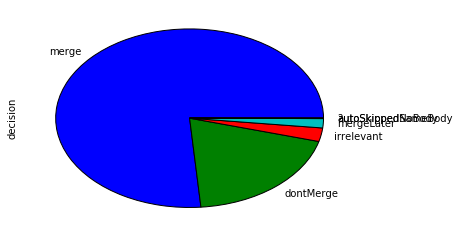

In [28]:
df['decision'].value_counts().plot(kind='pie')

In [29]:
df['decision'].value_counts()

merge                  110108
dontMerge               28043
irrelevant               3540
mergeLater               2424
?                          57
autoSkippedNoBody          28
autoSkippedSameBody        14
Name: decision, dtype: int64

In [30]:
df.to_csv('focused-decisions-20180801.csv')

In [32]:
len(df.query("decision == 'merge' or decision == 'dontMerge'"))

138151

In [ ]:
%time twohop_table = np.concatenate(table_chunks)

In [ ]:
twohop_scores = calc_scores(twohop_table)

In [ ]:
%time twohop_df = pd.DataFrame.from_records(twohop_table)

In [ ]:
twohop_df['score'] = twohop_scores

In [ ]:
%time twohop_subset_df = twohop_df.query('body_a % 20 == 0 or body_b % 20 == 0').copy()

In [ ]:
twohop_subset_df.shape

In [ ]:
del twohop_table
del twohop_df
del twohop_scores

In [ ]:
%%time
body_a_stats = twohop_subset_df.groupby('body_a').agg({'score': ['min']})
body_a_stats.columns = ['min_score']

body_b_stats = twohop_subset_df.groupby('body_b').agg({'score': ['min']})
body_b_stats.columns = ['min_score']

In [ ]:
%%time
merged_body_stats = pd.DataFrame(body_a_stats).merge(body_b_stats, 'outer', left_index=True, right_index=True,
                                                      suffixes=['_a', '_b'])

In [ ]:
%%time

# Combine scores/indexes and edge counts, and record which side of the edge the score came from.
min_scores = merged_body_stats[['min_score_a', 'min_score_b']].min(axis=1)
edge_counts = merged_body_stats[['edge_count_a', 'edge_count_b']].sum(axis=1).astype(np.uint32)

min_index = merged_body_stats['min_index_b'].copy()
pos_a = merged_body_stats['min_score_a'] < merged_body_stats['min_score_b']
min_index.loc[pos_a] = merged_body_stats['min_index_a']

sides = pd.Series('b', index=merged_body_stats.index)
sides.loc[pos_a] = 'a'
sides.loc[min_index.isnull()] = 'x'
sides = sides.astype('category')

twohop_body_stats = pd.DataFrame({'min_score': min_scores,
                                  'min_index': min_index,
                                  'edge_count': edge_counts,
                                  'side': sides})

In [ ]:
q = '(index in @important_bodies) and (index % 20 == 0)'
twohop_body_stats.query(q)['min_score'].hist()

In [ ]:
twohop_subset_df.iloc[:10].values.flags

In [ ]:
onehop_df['resolution'].value_counts().plot(kind='pie')

In [ ]:
onehop_df['resolution'].value_counts() / len(onehop_df['resolution'])

In [ ]:
%%time
best_edges_index = body_stats.drop(0).query('side != "x"')['min_index'].astype(np.int64)
best_onehop_df = onehop_df.loc[best_edges_index]

In [ ]:
best_onehop_df.shape

In [ ]:
resolution_fractions = best_onehop_df['resolution'].value_counts() / len(best_onehop_df['resolution'])
display(resolution_fractions)
resolution_fractions.plot(kind='pie')

In [ ]:
SMALL_BODY_CUTOFF = 155
small_body_stats = body_stats.drop(0).query('side != "x" and edge_count <= @SMALL_BODY_CUTOFF')
small_best_edges_index = small_body_stats['min_index'].astype(np.int64)

np.random.seed(0)
random_edges = np.random.choice(small_best_edges_index.values, 100, False)
assignment_table = onehop_df.loc[random_edges]

from neuclease.merge_table import generate_focused_assignment
_ = generate_focused_assignment(assignment_table, 'test-assignment-SMALL-BODIES-20180725.json')


In [ ]:
SCORE_CUTOFF = 0.9
good_score_body_stats = body_stats.drop(0).query('side != "x" and min_score <= @SCORE_CUTOFF')
good_best_edges_index = good_score_body_stats['min_index'].astype(np.int64)

print(f"Found {len(good_score_body_stats)}/{len(body_stats)} bodies with a good edge")

np.random.seed(0)
random_edges = np.random.choice(good_best_edges_index.values, 100, False)
assignment_table = onehop_df.loc[random_edges]

from neuclease.merge_table import generate_focused_assignment
_ = generate_focused_assignment(assignment_table, 'test-assignment-good-edges-20180725.json')


In [ ]:
SCORE_CUTOFF = 0.9
weak_score_body_stats = body_stats.drop(0).query('side != "x" and min_score > @SCORE_CUTOFF')
weak_best_edges_index = weak_score_body_stats['min_index'].astype(np.int64)

print(f"Found {len(weak_score_body_stats)}/{len(body_stats)} bodies with a weak edge")

np.random.seed(0)
random_edges = np.random.choice(weak_best_edges_index.values, 100, False)
assignment_table = onehop_df.loc[random_edges]

from neuclease.merge_table import generate_focused_assignment
_ = generate_focused_assignment(assignment_table, 'test-assignment-weak-edges-20180725.json')


In [ ]:
mutal_favorites = onehop_df.query('score <= @SCORE_CUTOFF and is_favorite_of_a and is_favorite_of_b')
print(f"Found {len(mutal_favorites)} mutual favorites")

In [ ]:
body_stats.query('edge_count > 0').shape

In [ ]:
348863 - 73350

In [ ]:
spec1.iloc[:10]

In [11]:
analysis_mapping = fetch_mappings(analysis_node)
analysis_mapper = LabelMapper(analysis_mapping.index.values, analysis_mapping.values)

Fetching http://emdata3:8900/api/node/662e/segmentation/mappings...
Fetching http://emdata3:8900/api/node/662e/segmentation/mappings took 0:00:30.986914
Parsing mapping...
Parsing mapping took 0:00:06.001045


In [ ]:
%%time
spec1['body_a'] = analysis_mapper.apply(spec1['id_a'].values, True)
spec1['body_b'] = analysis_mapper.apply(spec1['id_b'].values, True)

In [ ]:
spec1_important = spec1.query('(body_a in @important_bodies) and (body_b in @important_bodies)')

In [ ]:
spec1_important.shape

In [ ]:
my_best = set(map(tuple, np.sort(best_onehop_df[['id_a', 'id_b']].values, axis=1)))

In [ ]:
spec1_important_edges = set(map(tuple, np.sort(spec1_important[['id_a', 'id_b']].values, axis=1)))

In [ ]:
print(f"Did not recover {len(spec1_important_edges - my_best)} out of {len(spec1_important)} of Michal's merges")

In [ ]:
analysis_node